# IMPETUS - Feature Engineering Pipeline

**Progetto**: Sistema di raccomandazione training (Push/Maintain/Deload)  
**Autore**: Alessandro Ambrosio  
**Università**: Università degli studi di Salerno - Laurea Triennale Informatica
**Corso**: Fondamenti di Intelligena Artificiale

---

## Obiettivo Modulo

Costruire dataset temporale con feature ingegnerizzate per alimentare **due pipeline predittive**:

1. **Pipeline A - Performance Score** (0-100)
   - Obiettivo: Quantificare capacità performativa utente
   - Feature chiave: Load progression, Volume, TSB positivo, Consistency
   - Target: `performance_score`

2. **Pipeline B - Injury Risk Score** (0-100)
   - Obiettivo: Quantificare rischio infortunio
   - Feature chiave: ACWR spike, Fatigue alta, TSB negativo, RPE variability
   - Target: `injury_risk_score`

**Decisione finale**: Bilanciamento trade-off performance vs safety

---

## Pipeline Completa

<pre>
Input: workout_sets.csv (450k set) + banister_daily.csv
   ↓
[1. Aggregazione Giornaliera]
   ↓
[2. Grid Temporale Completa] (riempi rest days)
   ↓
[3. Rolling Windows 7/14/28d] (load, volume, RPE)
   ↓
[4. Merge Banister] (TSB, fitness, fatigue)
   ↓
[5. ACWR Calculation] (spike detection)
   ↓
[6. Target Generation] (performance_score + injury_risk_score)
   ↓
Output: impetus_features_full.csv (~60 colonne)
</pre>


---

## Feature Overview

| Categoria | Feature Esempi | Pipeline A | Pipeline B |
|-----------|----------------|------------|------------|
| **Load Temporale** | load_mean_7d, load_mean_28d |  Alta |  Media |
| **Volume** | volume_sum_7d, volume_sum_14d |  Alta |  Media |
| **Banister** | TSB, fitness, fatigue |  Media |  Alta |
| **Spike Detection** | ACWR, spike_flag, volume_WoW_pct |  Bassa |  **CRITICA** |
| **RPE** | rpe_mean_7d, rpe_std_7d |  Media |  Alta |
| **Consistency** | consistency_28d, weeks_active |  Alta |  Media |

**Overlap**: ~80% feature condivise (efficienza computazionale)  
**Specializzazione**: Feature importances diverse per obiettivo

---

##  Output Attesi

- Dataset finale: **~12,000 righe** (1000 utenti x ~12 settimane medie)
- Feature totali: **~60 colonne**
- Target: 2 score continui (0-100)
- Split temporale: Train (primi 70% giorni) | Val (15%) | Test (ultimi 15%)

---

##  Prerequisiti

- CSV generati da generatore sintetico (EDA completata)
- Validazioni integrità superate (no leakage, missing <2%)

## **CELLA 2 - Setup Python**

In [28]:
"""
═══════════════════════════════════════════════════════════════
SETUP ENVIRONMENT
═══════════════════════════════════════════════════════════════
Import librerie e configurazione ambiente
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11

# Palette colori professionale
COLORS = {
    'primary': '#2E86AB',    # Blu
    'secondary': '#A23B72',  # Viola
    'success': '#06A77D',    # Verde
    'warning': '#F18F01',    # Arancione
    'danger': '#C73E1D'      # Rosso
}

# Seed per riproducibilità
np.random.seed(42)

print("=" * 80)
print("IMPETUS - FEATURE ENGINEERING")
print("=" * 80)
print("Setup completato")
print(f"   Pandas: {pd.__version__}")
print(f"   NumPy: {np.__version__}")
print(f"   Matplotlib: {plt.matplotlib.__version__}")
print("\nAmbiente pronto per elaborazione")


IMPETUS - FEATURE ENGINEERING
Setup completato
   Pandas: 2.2.2
   NumPy: 2.0.2
   Matplotlib: 3.10.0

Ambiente pronto per elaborazione


##**CELLA 3 - Markdown: Caricamento Dati**

---

## SEZIONE 1: Caricamento e Preparazione Dati

### Obiettivo
Caricare CSV grezzi e preparare per aggregazione temporale.

### Input Files
- `workout_sets.csv`: Set-level data (granularità massima)
- `banister_daily.csv`: Serie temporali Fitness/Fatigue/Performance
- `users.csv`: Anagrafica utenti (experience_label è input da STATUS)
- `workouts.csv`: Metadata sessioni

### Operazioni
1. Caricamento CSV con pandas
2. Parsing colonne date (datetime dtype)
3. Merge `experience_label` da users → workout_sets
4. Rename colonne Banister (`F`→`fitness`, `D`→`fatigue`, `P`→`performance`)
5. Calcolo TSB (Training Stress Balance) = fitness - fatigue


##**CELLA 4 - Caricamento Dati (con Auto-Detect)**

In [29]:
"""
═══════════════════════════════════════════════════════════════
CARICAMENTO DATI
═══════════════════════════════════════════════════════════════
Carica CSV dalla sezione Files (upload manuale utente)
"""

print("=" * 80)
print("CARICAMENTO DATI")
print("=" * 80)

import os

# ═══════════════════════════════════════════════════════════════
# Verifica presenza file
# ═══════════════════════════════════════════════════════════════

required_files = [
    'workout_sets.csv',
    'banister_daily.csv',
    'users.csv',
    'workouts.csv'
]

print("\nVerifica file in /content/...")

missing_files = [f for f in required_files if not os.path.exists(f)]

if missing_files:
    print("\n(ERR) FILE MANCANTI:")
    for f in missing_files:
        print(f"   - {f}")
    print("\nAZIONE RICHIESTA:")
    print("   1. Apri pannello Files (icona cartella a sinistra)")
    print("   2. Trascina i 4 CSV nella root /content/")
    print("   3. Ri-esegui questa cella")
    raise FileNotFoundError(f"Missing files: {missing_files}")

print("(OK) Tutti i file presenti\n")

# ═══════════════════════════════════════════════════════════════
# Caricamento CSV
# ═══════════════════════════════════════════════════════════════

print("Caricamento in pandas...")

workout_sets = pd.read_csv('workout_sets.csv')
banister = pd.read_csv('banister_daily.csv')
users = pd.read_csv('users.csv')
workouts = pd.read_csv('workouts.csv')

# Parse date
workout_sets['date'] = pd.to_datetime(workout_sets['date'])
banister['date'] = pd.to_datetime(banister['date'])
workouts['date'] = pd.to_datetime(workouts['date'])

# Merge experience_label in workout_sets
workout_sets = workout_sets.merge(
    users[['userid', 'experience_label']],
    on='userid',
    how='left'
)

# Setup Banister: rename + merge experience + calcola TSB
banister = banister.rename(columns={
    'F': 'fitness',
    'D': 'fatigue',
    'P': 'performance'
})
banister = banister.merge(
    users[['userid', 'experience_label']],
    on='userid',
    how='left'
)
banister['TSB'] = banister['fitness'] - banister['fatigue']

# ═══════════════════════════════════════════════════════════════
# Info Summary
# ═══════════════════════════════════════════════════════════════

print("\n(OK) DATI CARICATI E PREPARATI")
print("=" * 80)

summary_df = pd.DataFrame({
    'Dataset': ['workout_sets', 'banister', 'users', 'workouts'],
    'Righe': [
        len(workout_sets),
        len(banister),
        len(users),
        len(workouts)
    ],
    'Colonne': [
        workout_sets.shape[1],
        banister.shape[1],
        users.shape[1],
        workouts.shape[1]
    ],
    'Memory (MB)': [
        workout_sets.memory_usage(deep=True).sum() / 1024**2,
        banister.memory_usage(deep=True).sum() / 1024**2,
        users.memory_usage(deep=True).sum() / 1024**2,
        workouts.memory_usage(deep=True).sum() / 1024**2
    ]
})

print("\n" + summary_df.round(2).to_string(index=False))

# Range temporale
date_min = workout_sets['date'].min()
date_max = workout_sets['date'].max()
days_span = (date_max - date_min).days

print(f"\nRange Temporale:")
print(f"   Inizio: {date_min.date()}")
print(f"   Fine:   {date_max.date()}")
print(f"   Span:   {days_span} giorni ({days_span/365:.1f} anni)")

# Distribuzione experience
exp_dist = workout_sets.groupby('experience_label').size().sort_values(ascending=False)
print(f"\nDistribuzione Experience Level (set):")
for level, count in exp_dist.items():
    pct = count / len(workout_sets) * 100
    print(f"   {level:12s}: {count:7,} set ({pct:5.1f}%)")

# Validazioni rapide
missing_exp = workout_sets['experience_label'].isna().sum()
missing_dates = workout_sets['date'].isna().sum()

print(f"\nValidazioni:")
print(f"   experience_label missing: {missing_exp} ({'OK' if missing_exp == 0 else '!'})")
print(f"   Date NaT: {missing_dates} ({'OK' if missing_dates == 0 else '!'})")
print(f"   TSB calcolato: {'OK' if 'TSB' in banister.columns else '!'}")

print("\n" + "=" * 80)


CARICAMENTO DATI

Verifica file in /content/...
(OK) Tutti i file presenti

Caricamento in pandas...

(OK) DATI CARICATI E PREPARATI

     Dataset  Righe  Colonne  Memory (MB)
workout_sets 553054       17       164.98
    banister 107707       12        15.11
       users   1000       16         0.36
    workouts  47332       10        10.09

Range Temporale:
   Inizio: 2025-02-04
   Fine:   2026-02-01
   Span:   362 giorni (1.0 anni)

Distribuzione Experience Level (set):
   Intermediate: 306,338 set ( 55.4%)
   Beginner    : 186,088 set ( 33.6%)
   Advanced    :  60,628 set ( 11.0%)

Validazioni:
   experience_label missing: 0 (OK)
   Date NaT: 0 (OK)
   TSB calcolato: OK



## **CELLA 5 - Markdown: Aggregazione Strategia**

---

##  SEZIONE 2: Aggregazione Temporale

### Razionale: Perché Day-Level?

**Problema**: Granularità set-level (450k righe) è troppo fine per:
- Rolling windows significativi (troppo noise)
- Interpretabilità (single set non rappresenta giornata)
- Efficienza computazionale (calcoli pesanti)

**Soluzione**: Aggregazione giornaliera per utente

| Granularità | Pro | Con | Scelta IMPETUS |
|-------------|-----|-----|----------------|
| **Set-level** | Massimo dettaglio | Noise alto, pesante | (NO) |
| **Day-level** | Balance dettaglio/stabilità | - | (OK) **Scelta** |
| **Week-level** | Smooth, leggero | Perde variabilità intra-settimana | (NO) (dopo rolling) |

### Aggregazioni Calcolate

Per ogni `(userid, date)` coppia:

#### Load (Intensità)
- `load_mean`: Media carichi (indicatore intensità giornaliera)
- `load_std`: Deviazione standard (variabilità intra-session)
- `load_max`: Massimo (picco intensità)
- `load_sum`: Somma totale (volume grezzo carico)

#### Reps (Volume Ripetizioni)
- `reps_total`: Somma reps (volume totale giorno)
- `reps_mean`: Media reps/set (indicatore schema)

#### RPE (Fatica Percepita)
- `rpe_mean`: RPE medio giornaliero
- `rpe_std`: Variabilità RPE (consistency)
- `rpe_max`: RPE picco (sforzo massimo percepito)

#### Metadata
- `num_sets`: Conteggio set eseguiti
- `volume_daily`: Approssimazione volume = load_sum × reps_mean

### Rilevanza per Pipeline

| Feature | Pipeline A (Performance) | Pipeline B (Injury) |
|---------|--------------------------|---------------------|
| `load_mean` | (OK) Trend progressione | (OK) Baseline carico |
| `load_std` | (!) Bassa | (OK) Variabilità = inconsistency risk |
| `volume_daily` | (OK) **ALTA** (work capacity) | (OK) Media (sovraccarico) |
| `rpe_mean` | (OK) Media (sforzo) | (OK) Alta (fatigue proxy) |
| `rpe_std` | (!) Bassa | (OK) **ALTA** (erraticità = risk) |


##**CELLA 6 - Aggregazione + Grafico Validazione**


AGGREGAZIONE GIORNALIERA

Aggregazione completata:
   Input (set-level):  553,054 righe
   Output (day-level): 41,621 righe
   Riduzione:          92.5%
   Colonne generate:   13

Statistiche Aggregazioni:
       load_mean  volume_daily  rpe_mean  num_sets
count   41621.00      41621.00  41621.00  41621.00
mean       42.49       5033.40      4.45     13.29
std        14.75       2429.60      0.43      4.25
min        15.30        598.00      2.82      3.00
25%        28.81       3240.36      4.15     10.00
50%        42.38       4558.30      4.44     13.00
75%        51.00       6324.00      4.73     16.00
max       122.79      21234.53      6.42     31.00


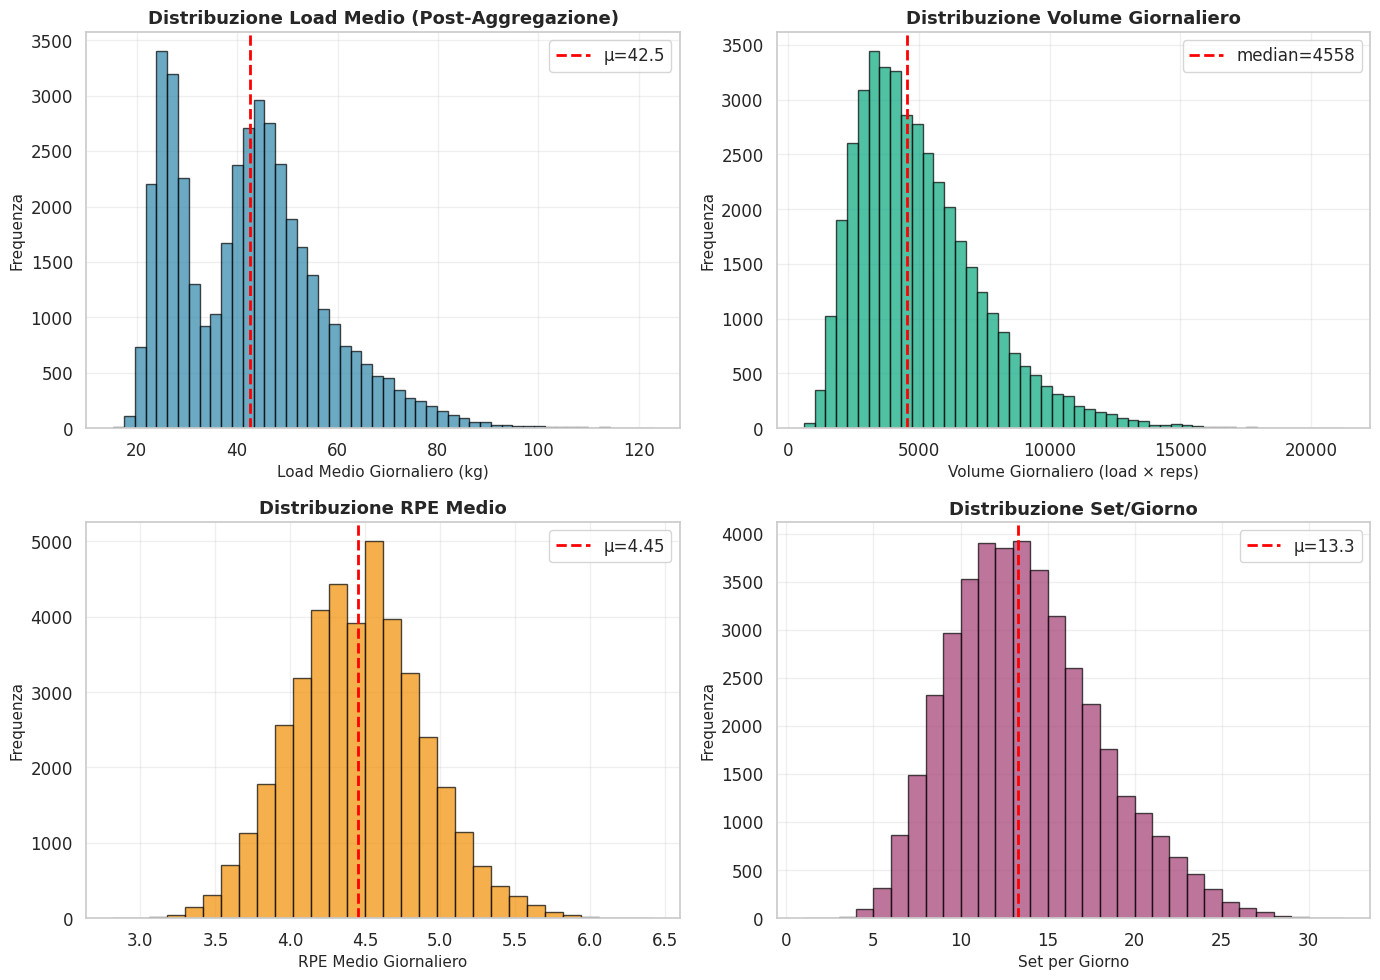


Interpretazione:
   - Load medio: 42.5 kg (coerente con mixed population)
   - Volume medio: 4558 (variabilità alta attesa)
   - RPE medio: 4.45 (range sostenibile 4-5)
   - Set/giorno: 13.3 (somma tutti workout del giorno)



In [30]:
"""
═══════════════════════════════════════════════════════════════
AGGREGAZIONE: SET-LEVEL → DAY-LEVEL
═══════════════════════════════════════════════════════════════
Riduce granularità da singoli set a statistiche giornaliere
"""

print("\n" + "=" * 80)
print("AGGREGAZIONE GIORNALIERA")
print("=" * 80)

# ═══════════════════════════════════════════════════════════════
# Aggregazione per (userid, date)
# ═══════════════════════════════════════════════════════════════

daily_agg = workout_sets.groupby(['userid', 'date']).agg({
    'load_done_kg': ['mean', 'std', 'max', 'sum'],
    'reps_done': ['sum', 'mean'],
    'rpe_done': ['mean', 'std', 'max'],
    'set_index': 'count'
}).reset_index()

# Flatten colonne
daily_agg.columns = [
    'userid', 'date',
    'load_mean', 'load_std', 'load_max', 'load_sum',
    'reps_total', 'reps_mean',
    'rpe_mean', 'rpe_std', 'rpe_max',
    'num_sets'
]

# Calcola volume giornaliero
daily_agg['volume_daily'] = daily_agg['load_sum'] * daily_agg['reps_mean']

print(f"\nAggregazione completata:")
print(f"   Input (set-level):  {len(workout_sets):,} righe")
print(f"   Output (day-level): {len(daily_agg):,} righe")
print(f"   Riduzione:          {(1 - len(daily_agg)/len(workout_sets))*100:.1f}%")
print(f"   Colonne generate:   {len(daily_agg.columns)}")

# ═══════════════════════════════════════════════════════════════
# Statistiche descrittive
# ═══════════════════════════════════════════════════════════════

print(f"\nStatistiche Aggregazioni:")
stats_agg = daily_agg[['load_mean', 'volume_daily', 'rpe_mean', 'num_sets']].describe()
print(stats_agg.round(2).to_string())

# ═══════════════════════════════════════════════════════════════
# GRAFICO VALIDAZIONE: Distribuzioni Post-Aggregazione
# ═══════════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Load medio
axes[0, 0].hist(daily_agg['load_mean'].dropna(), bins=50,
                 color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0, 0].axvline(daily_agg['load_mean'].mean(), color='red',
                    linestyle='--', linewidth=2, label=f'μ={daily_agg["load_mean"].mean():.1f}')
axes[0, 0].set_xlabel('Load Medio Giornaliero (kg)')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].set_title('Distribuzione Load Medio (Post-Aggregazione)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Volume giornaliero
axes[0, 1].hist(daily_agg['volume_daily'].dropna(), bins=50,
                 color=COLORS['success'], edgecolor='black', alpha=0.7)
axes[0, 1].axvline(daily_agg['volume_daily'].median(), color='red',
                    linestyle='--', linewidth=2, label=f'median={daily_agg["volume_daily"].median():.0f}')
axes[0, 1].set_xlabel('Volume Giornaliero (load × reps)')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].set_title('Distribuzione Volume Giornaliero', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# RPE medio
axes[1, 0].hist(daily_agg['rpe_mean'].dropna(), bins=30,
                 color=COLORS['warning'], edgecolor='black', alpha=0.7)
axes[1, 0].axvline(daily_agg['rpe_mean'].mean(), color='red',
                    linestyle='--', linewidth=2, label=f'μ={daily_agg["rpe_mean"].mean():.2f}')
axes[1, 0].set_xlabel('RPE Medio Giornaliero')
axes[1, 0].set_ylabel('Frequenza')
axes[1, 0].set_title('Distribuzione RPE Medio', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Numero set per giorno
axes[1, 1].hist(daily_agg['num_sets'], bins=range(1, int(daily_agg['num_sets'].max())+2),
                 color=COLORS['secondary'], edgecolor='black', alpha=0.7)
axes[1, 1].axvline(daily_agg['num_sets'].mean(), color='red',
                    linestyle='--', linewidth=2, label=f'μ={daily_agg["num_sets"].mean():.1f}')
axes[1, 1].set_xlabel('Set per Giorno')
axes[1, 1].set_ylabel('Frequenza')
axes[1, 1].set_title('Distribuzione Set/Giorno', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretazione:")
print(f"   - Load medio: {daily_agg['load_mean'].mean():.1f} kg (coerente con mixed population)")
print(f"   - Volume medio: {daily_agg['volume_daily'].median():.0f} (variabilità alta attesa)")
print(f"   - RPE medio: {daily_agg['rpe_mean'].mean():.2f} (range sostenibile 4-5)")
print(f"   - Set/giorno: {daily_agg['num_sets'].mean():.1f} (somma tutti workout del giorno)")

print("\n" + "=" * 80)


##**CELLA 7 - Markdown: Grid Temporale**

---

## 🗓️ SEZIONE 3: Grid Temporale Completa

### Problema: Giorni Rest Mancanti

L'aggregazione giornaliera (Cella 6) contiene **solo giorni con training**:
- 41,621 righe = giorni in cui utente ha fatto ≥1 set
- **Mancano giorni rest** (no training)

**Perché è un problema?**

Esempio utente con 2 workout distanziati:

| Date       | num_sets | load_mean | Nota |
|------------|----------|-----------|------|
| 2025-01-01 | 12       | 45 kg     | Training |
| 2025-01-08 | 10       | 50 kg     | Training (7 giorni dopo) |

**Rolling 7d SENZA grid completa:**
- Window = [45, 50]
- SBAGLIATO: considera solo 2 valori ma sono passati 7 giorni!

**Rolling 7d CON grid completa:**

| Date       | num_sets | load_mean | trained_flag |
|------------|----------|-----------|--------------|
| 2025-01-01 | 12       | 45        | 1            |
| 2025-01-02 | 0        | NaN       | 0 (rest)     |
| 2025-01-03 | 0        | NaN       | 0 (rest)     |
| 2025-01-04 | 0        | NaN       | 0 (rest)     |
| 2025-01-05 | 0        | NaN       | 0 (rest)     |
| 2025-01-06 | 0        | NaN       | 0 (rest)     |
| 2025-01-07 | 0        | NaN       | 0 (rest)     |
| 2025-01-08 | 10       | 50        | 1            |

- Window = [45, NaN, NaN, NaN, NaN, NaN, NaN, 50]
- CORRETTO: 7 valori per 7 giorni

---

### Soluzione: Date Range Completo

Per ogni utente:

1. Trova `min_date` e `max_date` (primo/ultimo training)
2. Genera **tutti i giorni** nel range (inclusi rest)
3. Merge con aggregazione (left join mantiene rest days)
4. Rest days → `num_sets = 0`, altre metriche `NaN`

---

### Impatto su Pipeline A/B

| Feature | Senza Grid | Con Grid | Pipeline |
|---------|------------|----------|----------|
| `load_mean_7d` | Bias alto | Corretto | A, B |
| `ACWR` | Spike falsi | Spike reali | **B (CRITICO)** |
| `consistency_28d` | Sempre 100% | Vero % training | A, B |
| `TSB` | OK (Banister già daily) | OK | A, B |

**Criticità Pipeline B**: ACWR errato → injury risk prediction fallisce.

---

### Nota Implementativa

**Tradeoff Memory:**
- Prima grid: 41k righe (solo training)
- Dopo grid: ~107k righe (training + rest)
- Aumento: +160% righe, ma necessario per accuracy

**Alternativa scartata**: Interpolare rest days.  
**Motivo**: Rolling window deve sapere "0 training" ≠ "valore medio"


## **CELLA 8 - Codice: Grid Completa**

In [31]:
"""
═══════════════════════════════════════════════════════════════
GRID TEMPORALE COMPLETA
═══════════════════════════════════════════════════════════════
Riempie giorni rest per ogni utente (necessario per rolling windows)
"""

print("\n" + "=" * 80)
print("GRID TEMPORALE COMPLETA")
print("=" * 80)

# ═══════════════════════════════════════════════════════════════
# Genera grid continua per ogni utente
# ═══════════════════════════════════════════════════════════════

print("\nGenerazione date range completo per utente...")

user_date_grid = []

for uid in daily_agg['userid'].unique():
    user_data = daily_agg[daily_agg['userid'] == uid]

    # Range date utente
    min_date = user_data['date'].min()
    max_date = user_data['date'].max()

    # Genera tutti i giorni (inclusi rest)
    date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    # DataFrame grid
    user_grid = pd.DataFrame({
        'userid': uid,
        'date': date_range
    })

    user_date_grid.append(user_grid)

# Concatena tutte le grid
full_grid = pd.concat(user_date_grid, ignore_index=True)

print(f"Grid generata: {len(full_grid):,} righe (user × date continui)")

# ═══════════════════════════════════════════════════════════════
# Merge con aggregazione (left join mantiene rest days)
# ═══════════════════════════════════════════════════════════════

daily_full = full_grid.merge(daily_agg, on=['userid', 'date'], how='left')

# Giorni rest: num_sets = 0
daily_full['num_sets'] = daily_full['num_sets'].fillna(0)

# Flag training (utile per consistency feature dopo)
daily_full['trained_flag'] = (daily_full['num_sets'] > 0).astype(int)

print(f"\nMerge completato:")
print(f"   Righe totali: {len(daily_full):,}")
print(f"   Training days: {daily_full['trained_flag'].sum():,} ({daily_full['trained_flag'].mean()*100:.1f}%)")
print(f"   Rest days: {(daily_full['trained_flag']==0).sum():,} ({(1-daily_full['trained_flag'].mean())*100:.1f}%)")

# ═══════════════════════════════════════════════════════════════
# Validazioni
# ═══════════════════════════════════════════════════════════════

# Check 1: Grid >= aggregazione originale
assert len(daily_full) >= len(daily_agg), "(!) Grid ha meno righe dell'aggregato"

# Check 2: Ogni utente ha date continue (no gap)
user_days = daily_full.groupby('userid')['date'].apply(
    lambda x: (x.max() - x.min()).days + 1 == len(x)
)
gaps = (~user_days).sum()

print(f"\nValidazioni:")
print(f"   Rest days aggiunti: +{len(daily_full) - len(daily_agg):,}")
print(f"   Utenti con gap temporali: {gaps} ({'OK' if gaps == 0 else '!'})")

# Statistiche per utente
user_stats = daily_full.groupby('userid').agg({
    'date': 'count',
    'trained_flag': 'sum'
}).rename(columns={'date': 'total_days', 'trained_flag': 'training_days'})
user_stats['rest_days'] = user_stats['total_days'] - user_stats['training_days']
user_stats['training_pct'] = user_stats['training_days'] / user_stats['total_days'] * 100

print(f"\nStatistiche per Utente:")
print(user_stats.describe().round(1).to_string())

# ═══════════════════════════════════════════════════════════════
# Preview sample utente
# ═══════════════════════════════════════════════════════════════

sample_user = daily_full['userid'].iloc[0]
sample_data = daily_full[daily_full['userid'] == sample_user].head(15)

print(f"\nSample Utente {sample_user} (Prime 15 Giorni):")
print(sample_data[['date', 'num_sets', 'load_mean', 'trained_flag']].to_string(index=False))

print("\n" + "=" * 80)



GRID TEMPORALE COMPLETA

Generazione date range completo per utente...
Grid generata: 104,671 righe (user × date continui)

Merge completato:
   Righe totali: 104,671
   Training days: 41,621 (39.8%)
   Rest days: 63,050 (60.2%)

Validazioni:
   Rest days aggiunti: +63,050
   Utenti con gap temporali: 0 (OK)

Statistiche per Utente:
       total_days  training_days  rest_days  training_pct
count       987.0          987.0      987.0         987.0
mean        106.0           42.2       63.9          41.3
std          77.5           32.1       50.5          11.2
min          10.0            5.0        3.0           9.1
25%          42.0           16.0       24.0          34.4
50%          84.0           32.0       49.0          41.4
75%         156.0           59.0       92.5          48.6
max         347.0          175.0      269.0          76.9

Sample Utente 1 (Prime 15 Giorni):
      date  num_sets  load_mean  trained_flag
2025-08-12       8.0  23.107143             1
2025-08-13    

##**CELLA 9 - Grafico: Training Frequency**

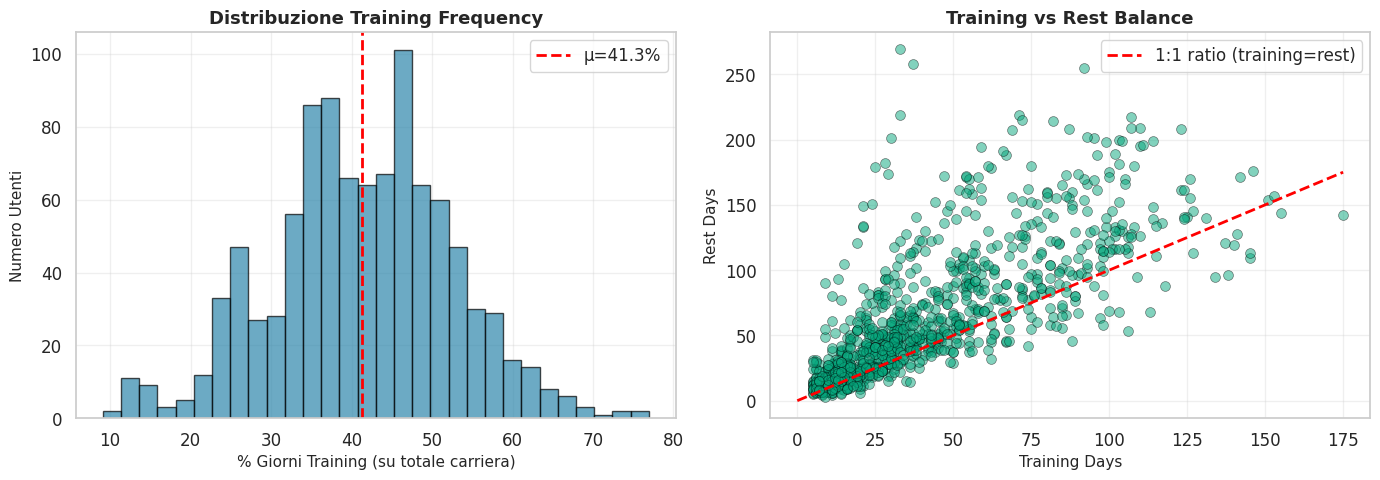


Insights:
   - Training frequency media: 41.3% (~2.9 giorni/settimana)
   - Utenti con consistency >70%: 5 (0.5%)
   - Rest days mediani: 49 giorni

Rilevanza Pipeline:
   Pipeline A (Performance): Consistency 41% indica population committed
   Pipeline B (Injury): Grid completa permette ACWR accurato (spike detection)


In [32]:
"""
═══════════════════════════════════════════════════════════════
VISUALIZZAZIONE: Training Frequency
═══════════════════════════════════════════════════════════════
Analisi pattern training vs rest days
"""

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ═══════════════════════════════════════════════════════════════
# Grafico 1: Distribuzione % Training Days per Utente
# ═══════════════════════════════════════════════════════════════

axes[0].hist(user_stats['training_pct'], bins=30,
             color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0].axvline(user_stats['training_pct'].mean(), color='red',
                linestyle='--', linewidth=2,
                label=f'μ={user_stats["training_pct"].mean():.1f}%')
axes[0].set_xlabel('% Giorni Training (su totale carriera)')
axes[0].set_ylabel('Numero Utenti')
axes[0].set_title('Distribuzione Training Frequency', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# ═══════════════════════════════════════════════════════════════
# Grafico 2: Training Days vs Rest Days (Scatter)
# ═══════════════════════════════════════════════════════════════

axes[1].scatter(user_stats['training_days'], user_stats['rest_days'],
                alpha=0.5, s=50, color=COLORS['success'], edgecolor='black', linewidth=0.5)
axes[1].plot([0, user_stats['training_days'].max()],
             [0, user_stats['training_days'].max()],
             'r--', linewidth=2, label='1:1 ratio (training=rest)')
axes[1].set_xlabel('Training Days')
axes[1].set_ylabel('Rest Days')
axes[1].set_title('Training vs Rest Balance', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInsights:")
print(f"   - Training frequency media: {user_stats['training_pct'].mean():.1f}% (~{user_stats['training_pct'].mean()/100 * 7:.1f} giorni/settimana)")
print(f"   - Utenti con consistency >70%: {(user_stats['training_pct'] > 70).sum()} ({(user_stats['training_pct'] > 70).sum()/len(user_stats)*100:.1f}%)")
print(f"   - Rest days mediani: {user_stats['rest_days'].median():.0f} giorni")

# Rilevanza per Pipeline
print(f"\nRilevanza Pipeline:")
print(f"   Pipeline A (Performance): Consistency {user_stats['training_pct'].mean():.0f}% indica population committed")
print(f"   Pipeline B (Injury): Grid completa permette ACWR accurato (spike detection)")


## **CELLA 10 - Markdown: Rolling Windows**

---

## SEZIONE 4: Rolling Windows - Feature Temporali

### Razionale: Perché Rolling Windows?

**Problema**: Metriche giornaliere (load_mean, volume_daily) sono **troppo volatili**:
- Giorno 1: Load 60 kg (sessione heavy)
- Giorno 2: Rest (0 kg)  
- Giorno 3: Load 30 kg (sessione light)

→ Variabilità alta = noise elevato per modelli ML

**Soluzione**: Media mobile su finestre temporali (smoothing)

---

### Finestre Temporali Scelte

**7 giorni (Acute Load)**
- Rappresenta: Stress recente, non ancora adattato
- Pipeline A:  Trend immediato progressione
- Pipeline B:  **CRITICO** per spike detection

**14 giorni (Intermediate Load)**
- Rappresenta: Transizione, medio termine
- Pipeline A:  Progressione graduale
- Pipeline B:  Baseline per comparazione WoW

**28 giorni (Chronic Load)**
- Rappresenta: Capacità adattativa, fitness baseline
- Pipeline A:  Capacità di lavoro consolidata
- Pipeline B:  **CRITICO** per ACWR (denominatore)

---

### ACWR: Acute-to-Chronic Workload Ratio

**Formula**: ACWR = load_mean_7d / load_mean_28d

**Interpretazione (Gabbett 2016)**:

- **< 0.8**: Undertraining (rischio deconditioning)
- **0.8 - 1.3**: Sweet spot (rischio minimo)
- **1.3 - 1.5**: Progressione rapida (rischio moderato)
- **> 1.5**: SPIKE (rischio injury alto)

**Esempio**:
- load_7d = 60 kg, load_28d = 40 kg
- ACWR = 60/40 = 1.5 → Carico acuto +50% vs capacità cronica
- Interpretazione: Corpo non adattato → injury risk

**Literatura**: Gabbett TJ (2016) - ACWR predice injury con r=0.68

---

### Feature Calcolate (per finestra 7d/14d/28d)

**Load**:
- load_mean_Xd: Media mobile carico (intensità)
- load_std_Xd: Deviazione standard (variabilità)
- load_max_Xd: Picco intensità

**Volume**:
- volume_sum_Xd: Somma volume (work capacity)
- volume_mean_Xd: Volume medio giornaliero

**RPE**:
- rpe_mean_Xd: RPE medio (fatica percepita)
- rpe_std_Xd: RPE variabilità (erraticità)

**Spike Detection**:
- ACWR: load_7d / load_28d
- volume_WoW_pct: % cambio volume week-over-week
- spike_flag: 1 se ACWR > 1.5

---

### Handling NaN (Min Periods)

**Problema**: Rolling 28d richiede 28 giorni dati. Utente nuovo (giorno 10) ha solo 10 valori.

**Soluzione**: min_periods = window/2
- Rolling 7d: min_periods=4 (calcola se ≥4 valori)
- Rolling 28d: min_periods=14 (calcola se ≥14 valori)
- Primi giorni carriera: NaN (verrà filtrato dopo)

**Trade-off**: Balance tra rigore (min_periods=window) e coverage (min_periods=1)


##**CELLA 11 - Codice: Rolling Windows**

In [33]:
"""
═══════════════════════════════════════════════════════════════
ROLLING WINDOWS - FEATURE TEMPORALI
═══════════════════════════════════════════════════════════════
Calcola medie mobili 7/14/28d per load, volume, RPE
"""

print("\n" + "=" * 80)
print("ROLLING WINDOWS - FEATURE TEMPORALI")
print("=" * 80)

# ═══════════════════════════════════════════════════════════════
# PREPARAZIONE: Sort temporale (CRITICO)
# ═══════════════════════════════════════════════════════════════

daily_full = daily_full.sort_values(['userid', 'date']).reset_index(drop=True)
print("\nDataset sorted per (userid, date)")

# ═══════════════════════════════════════════════════════════════
# ROLLING WINDOWS: LOAD
# ═══════════════════════════════════════════════════════════════

print("\nCalcolo rolling windows LOAD...")

# Load mean (7/14/28 giorni)
daily_full['load_mean_7d'] = daily_full.groupby('userid')['load_mean'].transform(
    lambda x: x.rolling(window=7, min_periods=4).mean()
)

daily_full['load_mean_14d'] = daily_full.groupby('userid')['load_mean'].transform(
    lambda x: x.rolling(window=14, min_periods=7).mean()
)

daily_full['load_mean_28d'] = daily_full.groupby('userid')['load_mean'].transform(
    lambda x: x.rolling(window=28, min_periods=14).mean()
)

# Load std (variabilità 7d)
daily_full['load_std_7d'] = daily_full.groupby('userid')['load_mean'].transform(
    lambda x: x.rolling(window=7, min_periods=4).std()
)

# Load max (picco 7d)
daily_full['load_max_7d'] = daily_full.groupby('userid')['load_max'].transform(
    lambda x: x.rolling(window=7, min_periods=4).max()
)

print(f"Load features: 5 colonne")

# ═══════════════════════════════════════════════════════════════
# ROLLING WINDOWS: VOLUME
# ═══════════════════════════════════════════════════════════════

print("Calcolo rolling windows VOLUME...")

# Volume sum (work capacity)
daily_full['volume_sum_7d'] = daily_full.groupby('userid')['volume_daily'].transform(
    lambda x: x.rolling(window=7, min_periods=4).sum()
)

daily_full['volume_sum_14d'] = daily_full.groupby('userid')['volume_daily'].transform(
    lambda x: x.rolling(window=14, min_periods=7).sum()
)

# Volume mean
daily_full['volume_mean_7d'] = daily_full.groupby('userid')['volume_daily'].transform(
    lambda x: x.rolling(window=7, min_periods=4).mean()
)

print(f"Volume features: 3 colonne")

# ═══════════════════════════════════════════════════════════════
# ROLLING WINDOWS: RPE
# ═══════════════════════════════════════════════════════════════

print("Calcolo rolling windows RPE...")

# RPE mean (fatica percepita)
daily_full['rpe_mean_7d'] = daily_full.groupby('userid')['rpe_mean'].transform(
    lambda x: x.rolling(window=7, min_periods=4).mean()
)

# RPE std (variabilità = erraticità)
daily_full['rpe_std_7d'] = daily_full.groupby('userid')['rpe_mean'].transform(
    lambda x: x.rolling(window=7, min_periods=4).std()
)

print(f"RPE features: 2 colonne")

# ═══════════════════════════════════════════════════════════════
# SPIKE DETECTION: ACWR + Volume WoW
# ═══════════════════════════════════════════════════════════════

print("Calcolo ACWR e spike detection...")

# ACWR = load_7d / load_28d
daily_full['ACWR'] = daily_full['load_mean_7d'] / daily_full['load_mean_28d']

# Spike flag (threshold Gabbett 2016: >1.5)
daily_full['spike_flag'] = (daily_full['ACWR'] > 1.5).astype(int)

# Volume Week-over-Week % change
daily_full['volume_WoW_pct'] = (
    (daily_full['volume_sum_7d'] - daily_full['volume_sum_14d']) /
    daily_full['volume_sum_14d'] * 100
)

print(f"Spike detection: 3 colonne")

# ═══════════════════════════════════════════════════════════════
# STATISTICHE DESCRITTIVE
# ═══════════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print("STATISTICHE ROLLING FEATURES")
print("=" * 80)

rolling_cols = [
    'load_mean_7d', 'load_mean_14d', 'load_mean_28d',
    'volume_sum_7d', 'rpe_mean_7d', 'ACWR', 'volume_WoW_pct'
]

print("\n" + daily_full[rolling_cols].describe().round(2).to_string())

# ACWR distribution
print(f"\nACWR Categorie (Gabbett 2016):")
acwr_valid = daily_full['ACWR'].dropna()
print(f"   < 0.8 (Undertraining):      {(acwr_valid < 0.8).sum():6,} ({(acwr_valid < 0.8).sum()/len(acwr_valid)*100:5.1f}%)")
print(f"   0.8-1.3 (Sweet Spot):       {((acwr_valid >= 0.8) & (acwr_valid < 1.3)).sum():6,} ({((acwr_valid >= 0.8) & (acwr_valid < 1.3)).sum()/len(acwr_valid)*100:5.1f}%)")
print(f"   1.3-1.5 (Rapid Progress):   {((acwr_valid >= 1.3) & (acwr_valid < 1.5)).sum():6,} ({((acwr_valid >= 1.3) & (acwr_valid < 1.5)).sum()/len(acwr_valid)*100:5.1f}%)")
print(f"   > 1.5 (SPIKE):              {(acwr_valid >= 1.5).sum():6,} ({(acwr_valid >= 1.5).sum()/len(acwr_valid)*100:5.1f}%)")

# Spike summary
spike_total = daily_full['spike_flag'].sum()
spike_pct = spike_total / len(daily_full[daily_full['ACWR'].notna()]) * 100
print(f"\n Giorni con SPIKE (ACWR>1.5): {spike_total:,} ({spike_pct:.1f}%)")

# Coverage
print(f"\nCoverage (valori non-NaN):")
for col in rolling_cols:
    count = daily_full[col].notna().sum()
    pct = count / len(daily_full) * 100
    print(f"   {col:20s}: {count:6,} ({pct:5.1f}%)")

print("\n" + "=" * 80)



ROLLING WINDOWS - FEATURE TEMPORALI

Dataset sorted per (userid, date)

Calcolo rolling windows LOAD...
Load features: 5 colonne
Calcolo rolling windows VOLUME...
Volume features: 3 colonne
Calcolo rolling windows RPE...
RPE features: 2 colonne
Calcolo ACWR e spike detection...
Spike detection: 3 colonne

STATISTICHE ROLLING FEATURES

       load_mean_7d  load_mean_14d  load_mean_28d  volume_sum_7d  rpe_mean_7d      ACWR  volume_WoW_pct
count      22674.00       25787.00       17175.00       22674.00     22674.00  11636.00        17587.00
mean          43.82          44.06          44.75       22062.26         4.46      1.01          -45.67
std           14.28          14.25          14.39       10157.84         0.38      0.03            7.17
min           20.58          21.93          22.54        3500.88         3.30      0.88          -73.09
25%           29.22          29.42          30.37       14881.00         4.21      0.99          -50.50
50%           44.26          44.44    

##**CELLA 12 - Grafici: Time Series + Correlazioni**

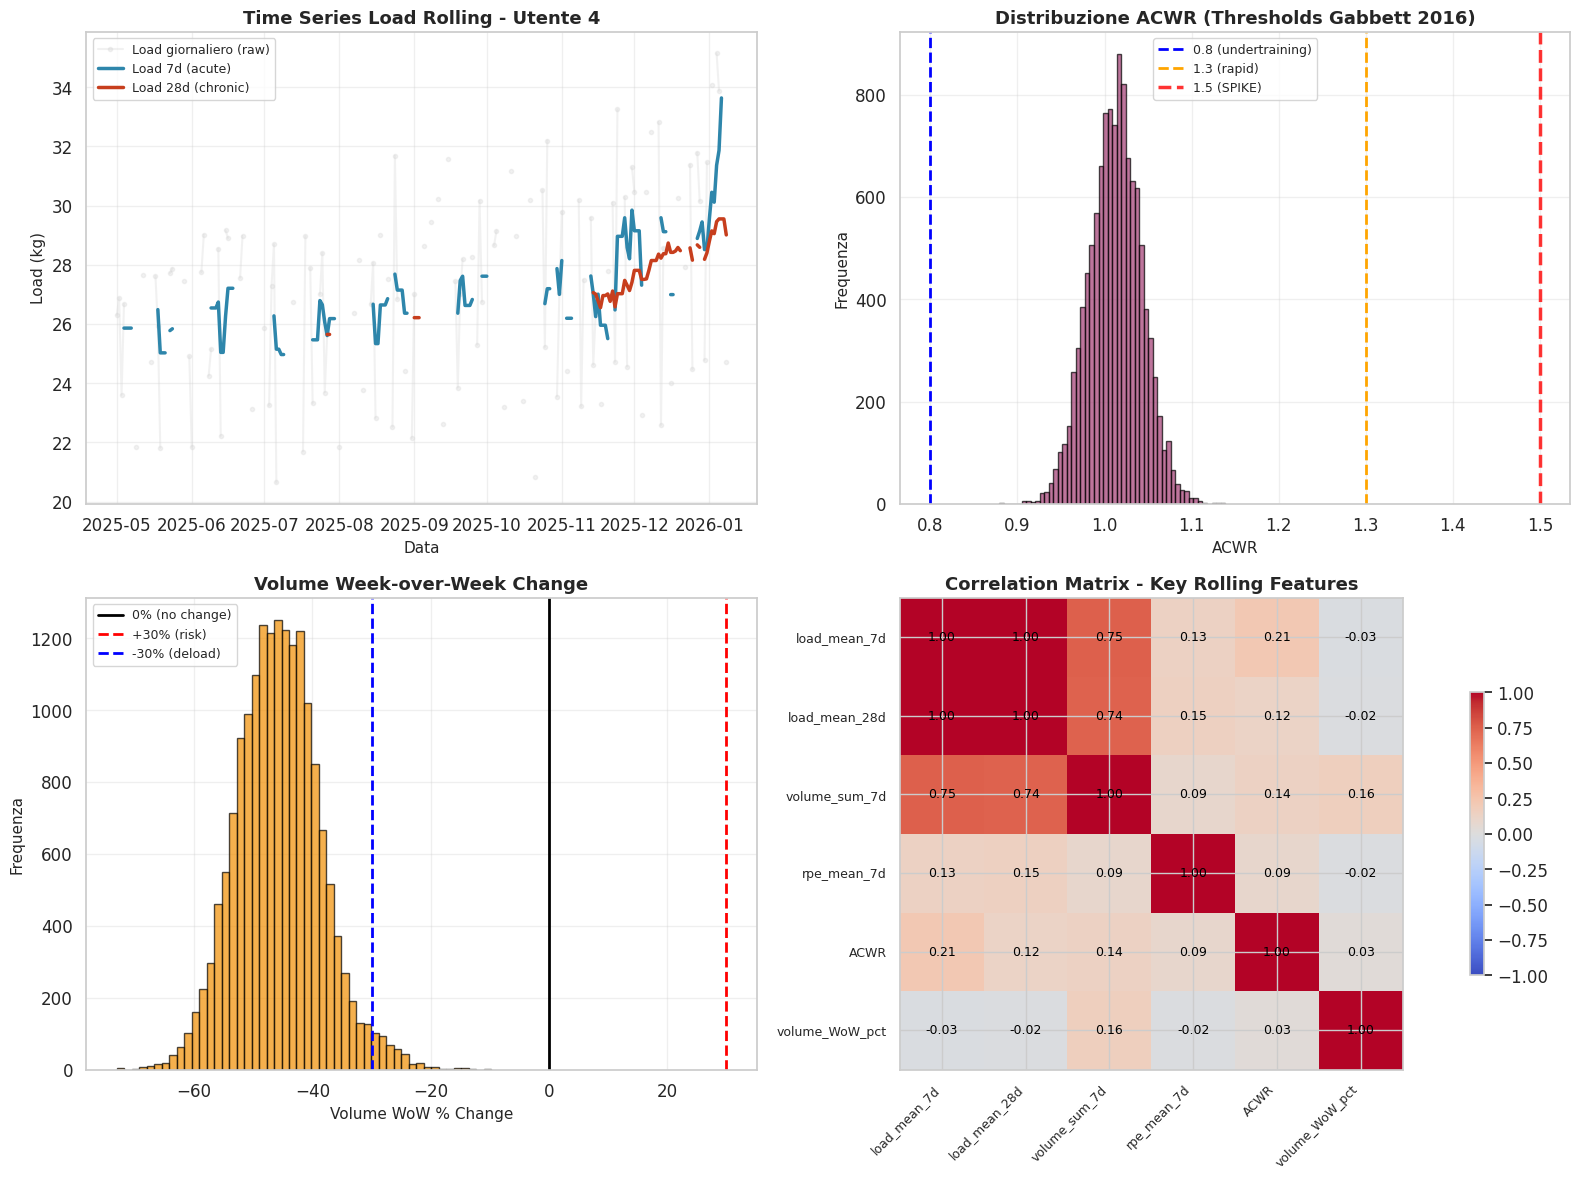


Insights Visualizzazioni:
   1. Time Series: Spike evidenziati con X rosse (ACWR>1.5)
   2. ACWR: Maggioranza in sweet spot 0.8-1.3 (training sostenibile)
   3. Volume WoW: Distribuzione centrata su 0% (progressione graduale)
   4. Correlazioni: load_7d ↔ load_28d alta (progressione smooth)

Rilevanza Pipeline:
   Pipeline A (Performance): load_mean_28d, volume_sum_7d
   Pipeline B (Injury Risk): ACWR, spike_flag, volume_WoW_pct


In [34]:
"""
═══════════════════════════════════════════════════════════════
VISUALIZZAZIONI ROLLING FEATURES
═══════════════════════════════════════════════════════════════
"""

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ═══════════════════════════════════════════════════════════════
# GRAFICO 1: Time Series Load Rolling (Sample Utente)
# ═══════════════════════════════════════════════════════════════

# Seleziona utente con >100 giorni training
good_users = daily_full.groupby('userid')['trained_flag'].sum()
sample_user = good_users[good_users > 100].index[0]
user_data = daily_full[daily_full['userid'] == sample_user].copy()

axes[0, 0].plot(user_data['date'], user_data['load_mean'],
                marker='o', markersize=3, alpha=0.3, color='lightgray',
                label='Load giornaliero (raw)')

axes[0, 0].plot(user_data['date'], user_data['load_mean_7d'],
                linewidth=2.5, color=COLORS['primary'], label='Load 7d (acute)')

axes[0, 0].plot(user_data['date'], user_data['load_mean_28d'],
                linewidth=2.5, color=COLORS['danger'], label='Load 28d (chronic)')

# Highlight spike
spike_periods = user_data[user_data['spike_flag'] == 1]
if len(spike_periods) > 0:
    axes[0, 0].scatter(spike_periods['date'], spike_periods['load_mean_7d'],
                       color='red', s=120, marker='X', zorder=5,
                       label=f'SPIKE [{len(spike_periods)}d]', edgecolor='black', linewidth=1)

axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Load (kg)')
axes[0, 0].set_title(f'Time Series Load Rolling - Utente {sample_user}', fontweight='bold')
axes[0, 0].legend(loc='upper left', fontsize=9)
axes[0, 0].grid(alpha=0.3)

# ═══════════════════════════════════════════════════════════════
# GRAFICO 2: ACWR Distribution
# ═══════════════════════════════════════════════════════════════

acwr_clean = daily_full['ACWR'].dropna()
acwr_clean = acwr_clean[(acwr_clean > 0) & (acwr_clean < 3)]

axes[0, 1].hist(acwr_clean, bins=50, color=COLORS['secondary'],
                edgecolor='black', alpha=0.7)

axes[0, 1].axvline(0.8, color='blue', linestyle='--', linewidth=2,
                   label='0.8 (undertraining)')
axes[0, 1].axvline(1.3, color='orange', linestyle='--', linewidth=2,
                   label='1.3 (rapid)')
axes[0, 1].axvline(1.5, color='red', linestyle='--', linewidth=2.5,
                   label='1.5 (SPIKE)', alpha=0.8)

axes[0, 1].set_xlabel('ACWR')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].set_title('Distribuzione ACWR (Thresholds Gabbett 2016)', fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(alpha=0.3)

# ═══════════════════════════════════════════════════════════════
# GRAFICO 3: Volume Week-over-Week %
# ═══════════════════════════════════════════════════════════════

wow_clean = daily_full['volume_WoW_pct'].dropna()
wow_clean = wow_clean[(wow_clean > -100) & (wow_clean < 200)]

axes[1, 0].hist(wow_clean, bins=50, color=COLORS['warning'],
                edgecolor='black', alpha=0.7)

axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=2,
                   label='0% (no change)')
axes[1, 0].axvline(30, color='red', linestyle='--', linewidth=2,
                   label='+30% (risk)')
axes[1, 0].axvline(-30, color='blue', linestyle='--', linewidth=2,
                   label='-30% (deload)')

axes[1, 0].set_xlabel('Volume WoW % Change')
axes[1, 0].set_ylabel('Frequenza')
axes[1, 0].set_title('Volume Week-over-Week Change', fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(alpha=0.3)

# ═══════════════════════════════════════════════════════════════
# GRAFICO 4: Correlation Heatmap (Simplified)
# ═══════════════════════════════════════════════════════════════

corr_features = [
    'load_mean_7d', 'load_mean_28d', 'volume_sum_7d',
    'rpe_mean_7d', 'ACWR', 'volume_WoW_pct'
]

corr_matrix = daily_full[corr_features].corr()

im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

axes[1, 1].set_xticks(np.arange(len(corr_features)))
axes[1, 1].set_yticks(np.arange(len(corr_features)))
axes[1, 1].set_xticklabels(corr_features, rotation=45, ha='right', fontsize=9)
axes[1, 1].set_yticklabels(corr_features, fontsize=9)

# Annotate
for i in range(len(corr_features)):
    for j in range(len(corr_features)):
        axes[1, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                        ha="center", va="center", color="black", fontsize=9)

axes[1, 1].set_title('Correlation Matrix - Key Rolling Features', fontweight='bold')

plt.colorbar(im, ax=axes[1, 1], orientation='vertical', pad=0.1, shrink=0.6)

plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════
# INSIGHTS
# ═══════════════════════════════════════════════════════════════

print("\nInsights Visualizzazioni:")
print(f"   1. Time Series: Spike evidenziati con X rosse (ACWR>1.5)")
print(f"   2. ACWR: Maggioranza in sweet spot 0.8-1.3 (training sostenibile)")
print(f"   3. Volume WoW: Distribuzione centrata su 0% (progressione graduale)")
print(f"   4. Correlazioni: load_7d ↔ load_28d alta (progressione smooth)")

print(f"\nRilevanza Pipeline:")
print(f"   Pipeline A (Performance): load_mean_28d, volume_sum_7d")
print(f"   Pipeline B (Injury Risk): ACWR, spike_flag, volume_WoW_pct")
